In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif']=['Simhei']  #显示中文
# plt.rcParams['axes.unicode_minus']=False    #显示负号
%config InlineBackend.figure_format = 'retina'
from lmfit.models import LinearModel,VoigtModel,SplineModel

from scipy.signal import find_peaks
from peakutils import baseline

import os

path = 'figs/'

# Celibration

## Linear Celibrantion

In [2]:
os.listdir('data/beta/')

['10.chn',
 '10.txt',
 '15.chn',
 '15.txt',
 '18.8.chn',
 '18_8.txt',
 '20_8.chn',
 '20_8.txt',
 '5.chn',
 '5.txt',
 'beta.chn',
 'beta.txt',
 'brta.chn',
 'brta.txt']

In [3]:
txtfiles = ['5.txt','10.txt','15.txt','18_8.txt','20_8.txt']
data_dict = {txtfile:pd.read_csv('data/beta/' + txtfile, sep='\t')['1'].values \
             for txtfile in txtfiles}
data_linear_celibration = pd.DataFrame(data_dict)
data_linear_celibration.columns = ['5mV','10mV','15mV','18.8mV','20.8mV']
data_linear_celibration

,5mV,10mV,15mV,18.8mV,20.8mV
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
1019,0,0,0,0,0
1020,0,0,0,0,0
1021,0,0,0,0,0
1022,0,0,0,0,0


Text(0, 0.5, 'Count')

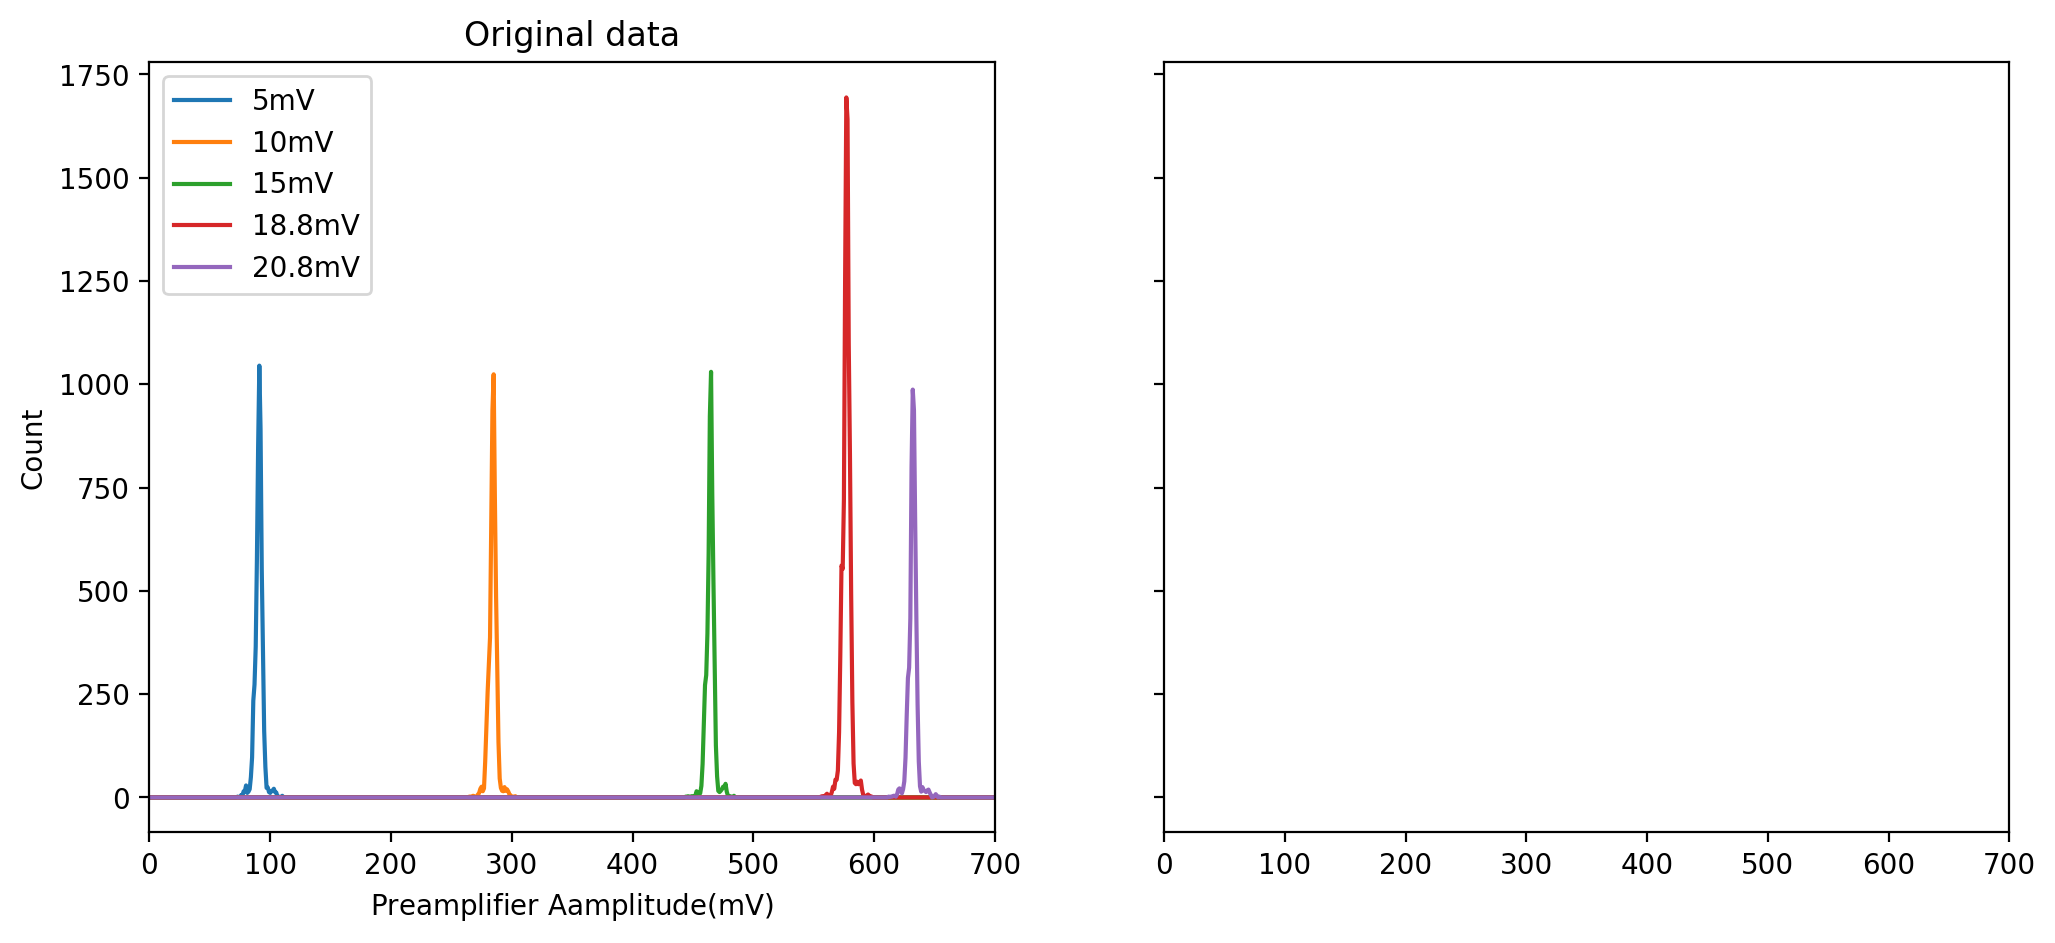

In [4]:
fig,axes = plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
data_linear_celibration.plot(ax = axes[0])
axes[0].set_xlim(0,700)
axes[0].set_title('Original data')
axes[0].set_xlabel(r'Preamplifier Aamplitude($\rm{mV}$)')
axes[0].set_ylabel('Count')

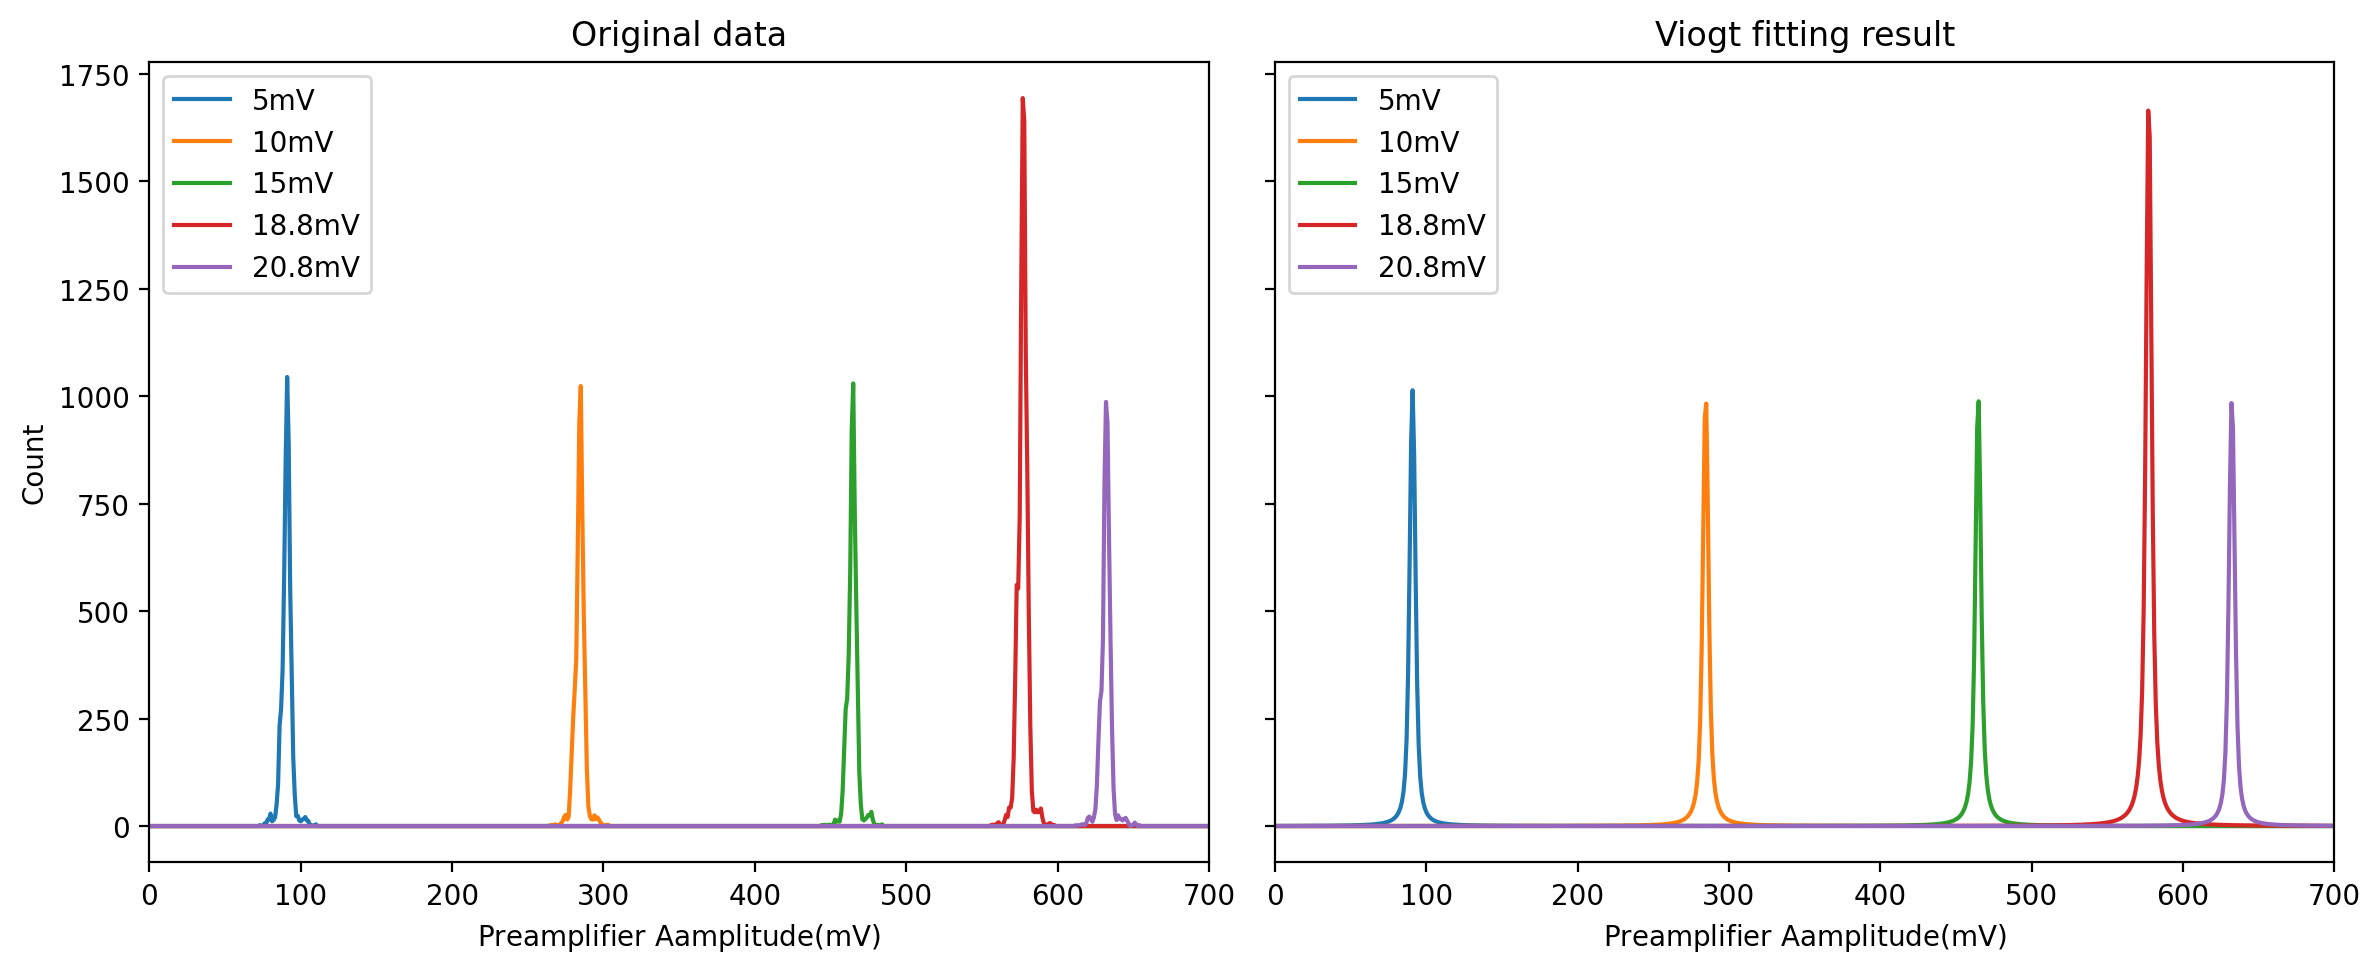

([91, 285, 465, 577, 632],
 [90.94315096147045,
  284.615449197184,
  464.69686662489113,
  577.3777226325575,
  632.286003704376])

In [5]:
peaks = []
peaks_voigt = []
for col in data_linear_celibration.columns:
    data = data_linear_celibration[col].values
    x_data = np.arange(0,len(data),1)
    peak,_ = find_peaks(data, prominence = 800 )
    peaks.append(peak[0])
    model = VoigtModel()
    params = model.guess(data, x=x_data)
    params['gamma'].set( vary=True)
    result = model.fit(data, params, x=x_data)
    peaks_voigt.append(result.params['center'].value)
    axes[1].plot(x_data, result.best_fit, label=col)

axes[1].set_title('Viogt fitting result')
axes[1].set_xlabel(r'Preamplifier Aamplitude($\rm{mV}$)')
axes[1].set_ylabel('Count')
axes[1].legend()
fig.tight_layout()
fig.savefig(path + 'linear_celibration.pdf')
display(fig)

peaks,peaks_voigt

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 5
    # variables        = 2
    chi-square         = 752.959090
    reduced chi-square = 250.986363
    Akaike info crit   = 29.0728649
    Bayesian info crit = 28.2917407
    R-squared          = 0.99619596
[[Variables]]
    slope:      34.3364234 +/- 1.22502400 (3.57%) (init = 1)
    intercept: -67.9791756 +/- 18.4656267 (27.16%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9235


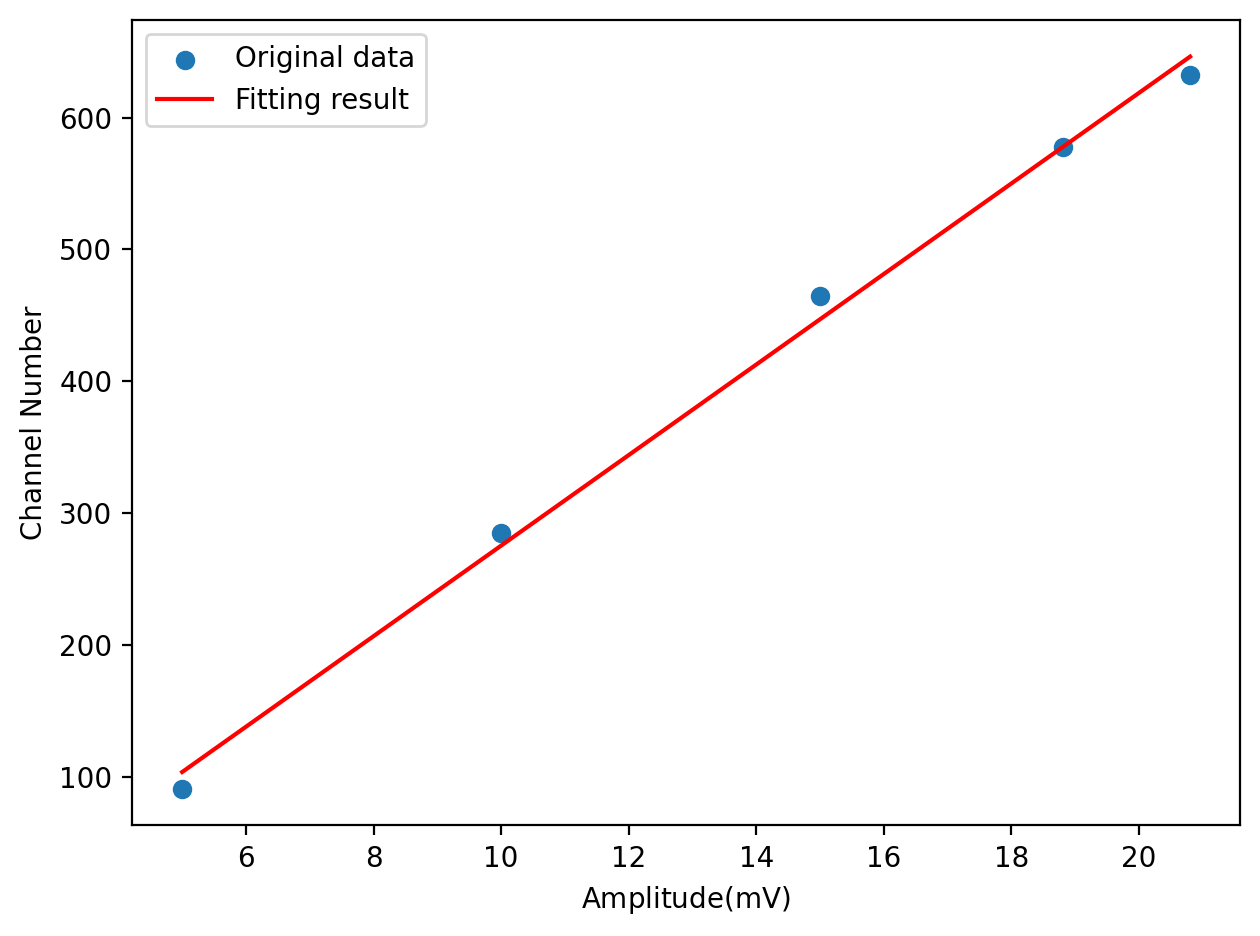

In [6]:
x = [eval(i[:-2]) for i in data_linear_celibration.columns]
y = peaks_voigt

linear_model = LinearModel()
fit_result = linear_model.fit(y, x=x)

print(fit_result.fit_report())

plt.scatter(x, y, label='Original data')
x_plot = np.linspace(min(x), max(x), 1001)
plt.plot(x_plot,
         fit_result.eval(x=x_plot),
         label='Fitting result', color='r')
plt.xlabel(r'Amplitude(${\rm mV}$)')
plt.ylabel(r'Channel Number')
plt.legend()
plt.tight_layout()
plt.savefig(path+'linear_fit.pdf')
plt.show()

In [7]:
celi_B = fit_result.params['slope'].value
celi_Bstderr = fit_result.params['slope'].stderr
print(celi_B,celi_Bstderr)

34.3364234408808 1.2250239979234592


## One Energy Celibration

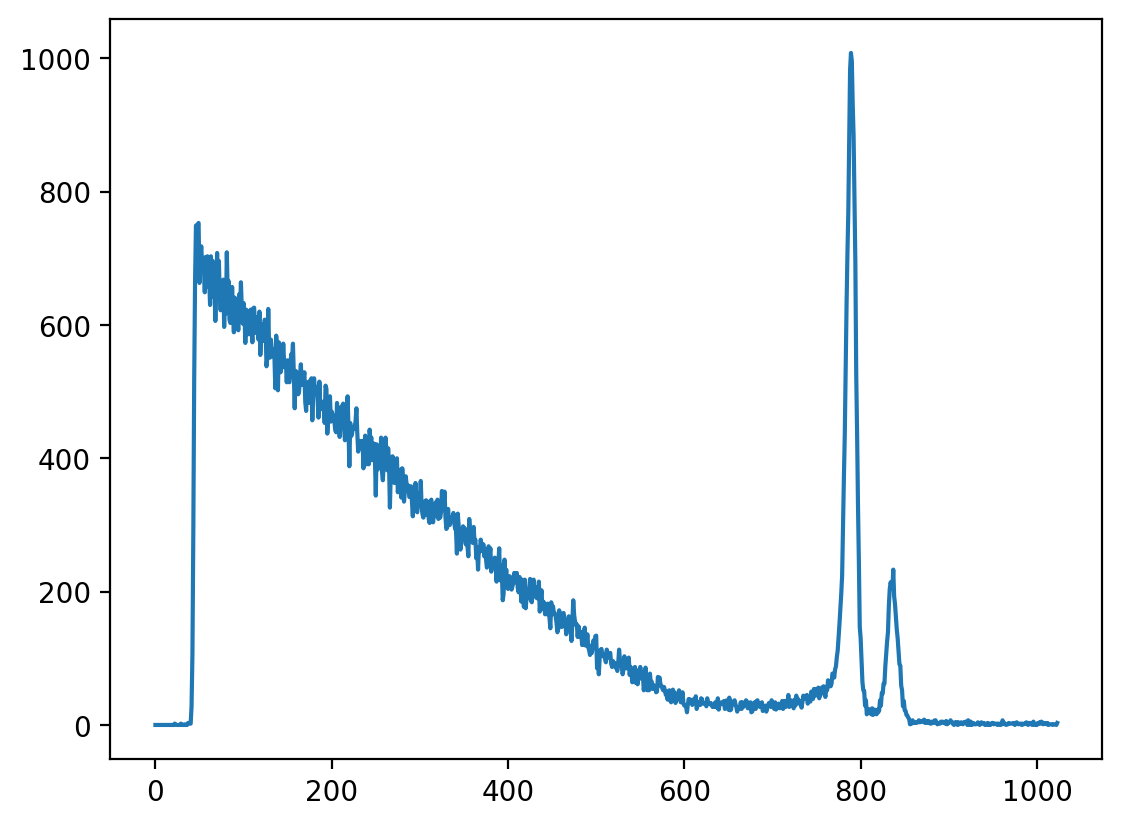

In [8]:
beta_spetrum = pd.read_csv('data/beta/beta.txt', sep='\t')['1'].values
plt.plot(beta_spetrum)
plt.show()

Text(0, 0.5, 'Counts')

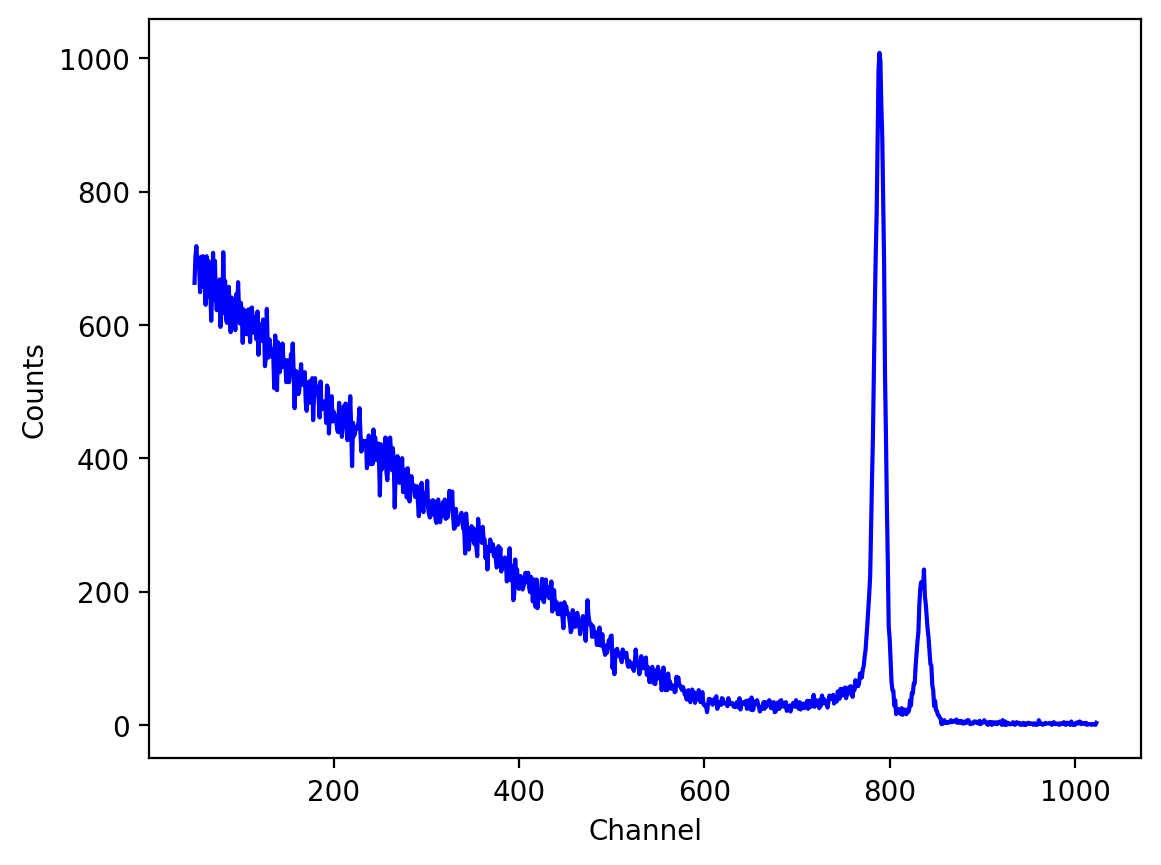

In [9]:
beta_spetrum_dropped = beta_spetrum[50:]
channel_dropped = np.arange(50,1024,1)
# bl = baseline(beta_spetrum[50:],deg=4)
# print(bl)
fig,ax = plt.subplots()
ax.plot(channel_dropped,beta_spetrum_dropped,color = 'blue',label = r'$\beta$ Spectrum')
ax.set_xlabel('Channel')
ax.set_ylabel('Counts')

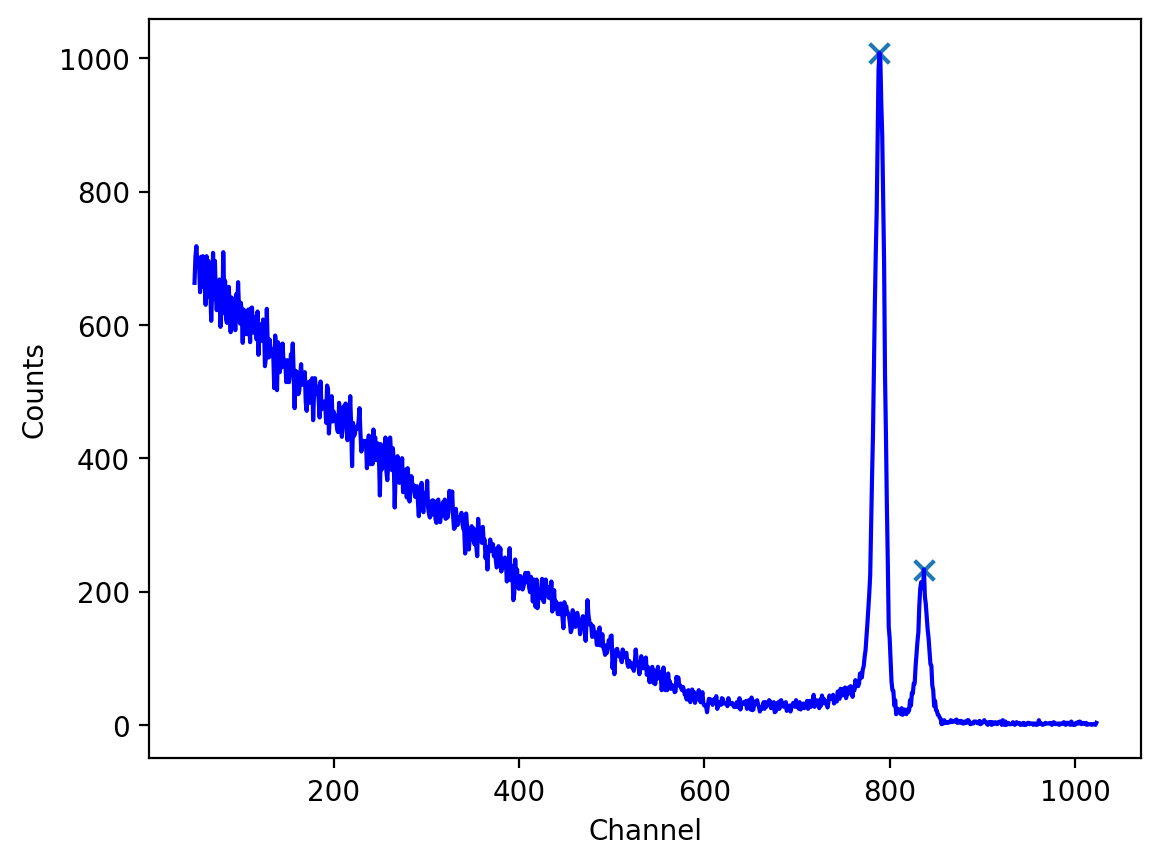

array([789, 837])

In [10]:
peaks,info = find_peaks(beta_spetrum_dropped,prominence=150,width = 10)
ax.scatter(channel_dropped[peaks],beta_spetrum_dropped[peaks],marker='x',s = 50)
display(fig)
channel_dropped[peaks]

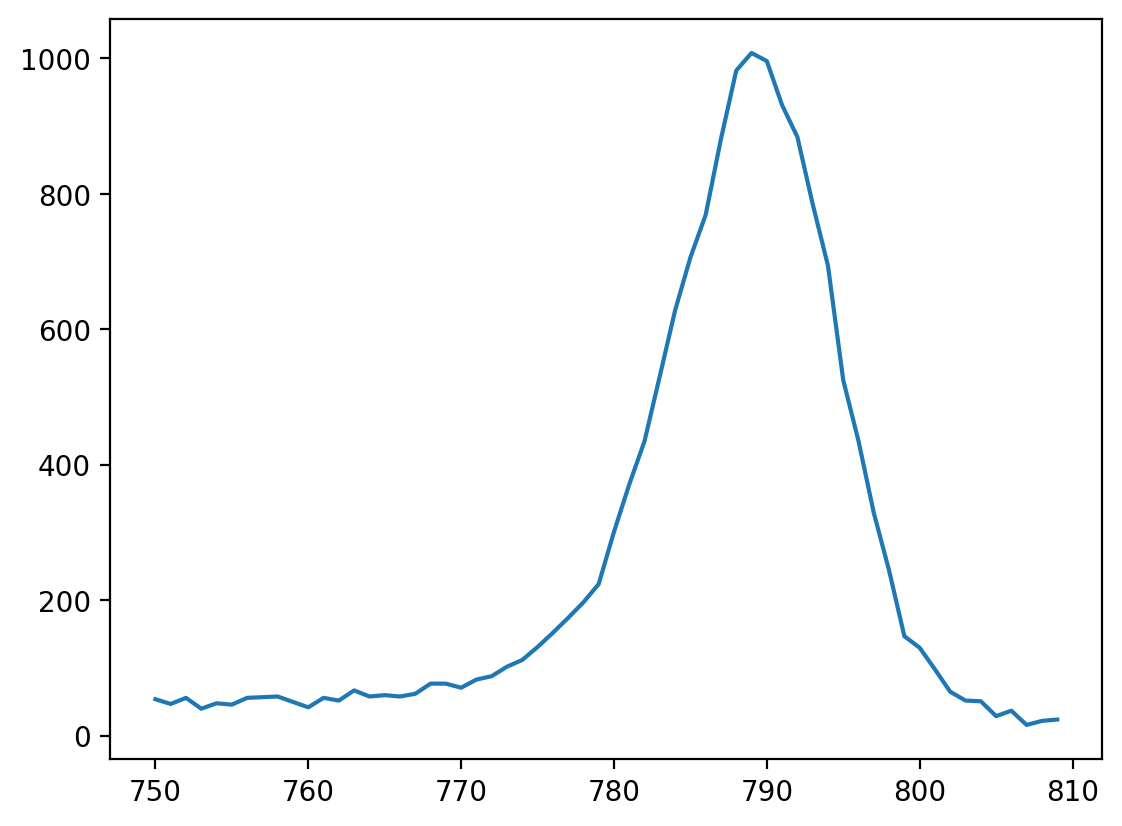

In [11]:
plt.plot(channel_dropped[700:760],beta_spetrum_dropped[700:760])

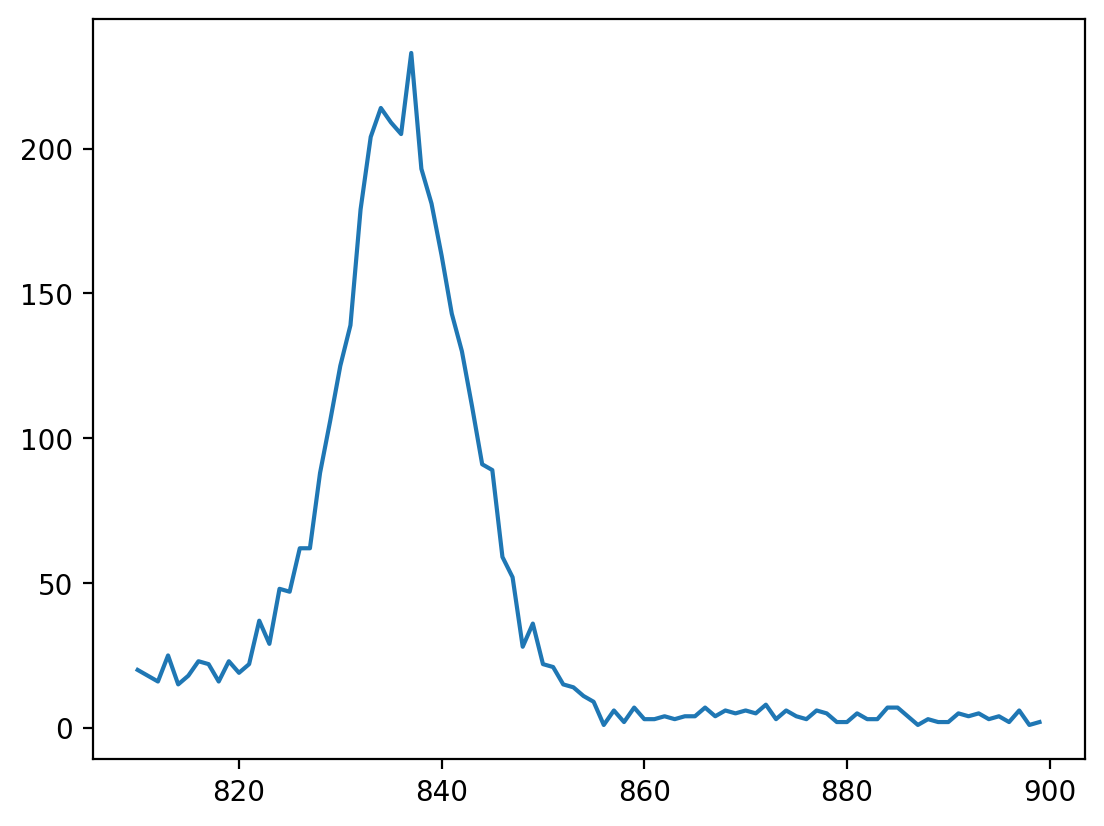

In [12]:
plt.plot(channel_dropped[760:850],beta_spetrum_dropped[760:850])

In [13]:
Viogt1 = VoigtModel(prefix='peak1_')
# params = Viogt1.make_params(center=channel_dropped[peaks[0]],amplitude = 1000,)
params = Viogt1.guess(beta_spetrum_dropped[700:760],channel_dropped[700:760])
Viogt2 = VoigtModel(prefix='peak2_')
params.update(Viogt2.guess(beta_spetrum_dropped[760:850],channel_dropped[760:850]))
params['peak1_gamma'].set(value = 0.7,vary=True,min = 0)
params['peak2_gamma'].set(value = 0.7,vary=True,min = 0)
knot_xvals = np.arange(200,1100,100)
bkg = SplineModel(prefix='bkg_', xknots=knot_xvals)
params.update(bkg.guess(beta_spetrum_dropped, channel_dropped))

name,value,initial value,min,max,vary,expression
peak1_amplitude,26784.0000,26784.0,-inf,inf,True,
peak1_center,789.000000,789.0,-inf,inf,True,
peak1_sigma,3.90000000,3.9000000000000004,0.00000000,inf,True,
peak1_gamma,0.70000000,0.7,0.00000000,inf,True,
peak1_fwhm,9.95524446,None,-inf,inf,False,1.0692*peak1_gamma+sqrt(0.8664*peak1_gamma**2+5.545083*peak1_sigma**2)
peak1_height,2387.69313,None,-inf,inf,False,"(peak1_amplitude/(max(1e-15, peak1_sigma*sqrt(2*pi))))*real(wofz((1j*peak1_gamma)/(max(1e-15, peak1_sigma*sqrt(2)))))"
peak2_amplitude,6264.00000,6264.0,-inf,inf,True,
peak2_center,836.000000,836.0,-inf,inf,True,
peak2_sigma,3.90000000,3.9000000000000004,0.00000000,inf,True,
peak2_gamma,0.70000000,0.7,0.00000000,inf,True,


In [14]:
model = Viogt1 + Viogt2 + bkg
out = model.fit(beta_spetrum_dropped, params, x=channel_dropped)
print(out.fit_report(min_correl=0.3))

[[Model]]
    ((Model(voigt, prefix='peak1_') + Model(voigt, prefix='peak2_')) + Model(spline_model, prefix='bkg_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 264
    # data points      = 974
    # variables        = 17
    chi-square         = 234693.621
    reduced chi-square = 245.238894
    Akaike info crit   = 5376.02465
    Bayesian info crit = 5459.00864
    R-squared          = 0.99495858
[[Variables]]
    peak1_amplitude:  14712.6809 +/- 295.095005 (2.01%) (init = 26784)
    peak1_center:     789.072731 +/- 0.04085994 (0.01%) (init = 789)
    peak1_sigma:      4.27582023 +/- 0.16031160 (3.75%) (init = 3.9)
    peak1_gamma:      2.02300159 +/- 0.25462211 (12.59%) (init = 0.7)
    peak1_fwhm:       12.4062604 +/- 0.12391095 (1.00%) == '1.0692*peak1_gamma+sqrt(0.8664*peak1_gamma**2+5.545083*peak1_sigma**2)'
    peak1_height:     976.633845 +/- 8.08753220 (0.83%) == '(peak1_amplitude/(max(1e-15, peak1_sigma*sqrt(2*pi))))*real(wofz((1j*peak1_gamma

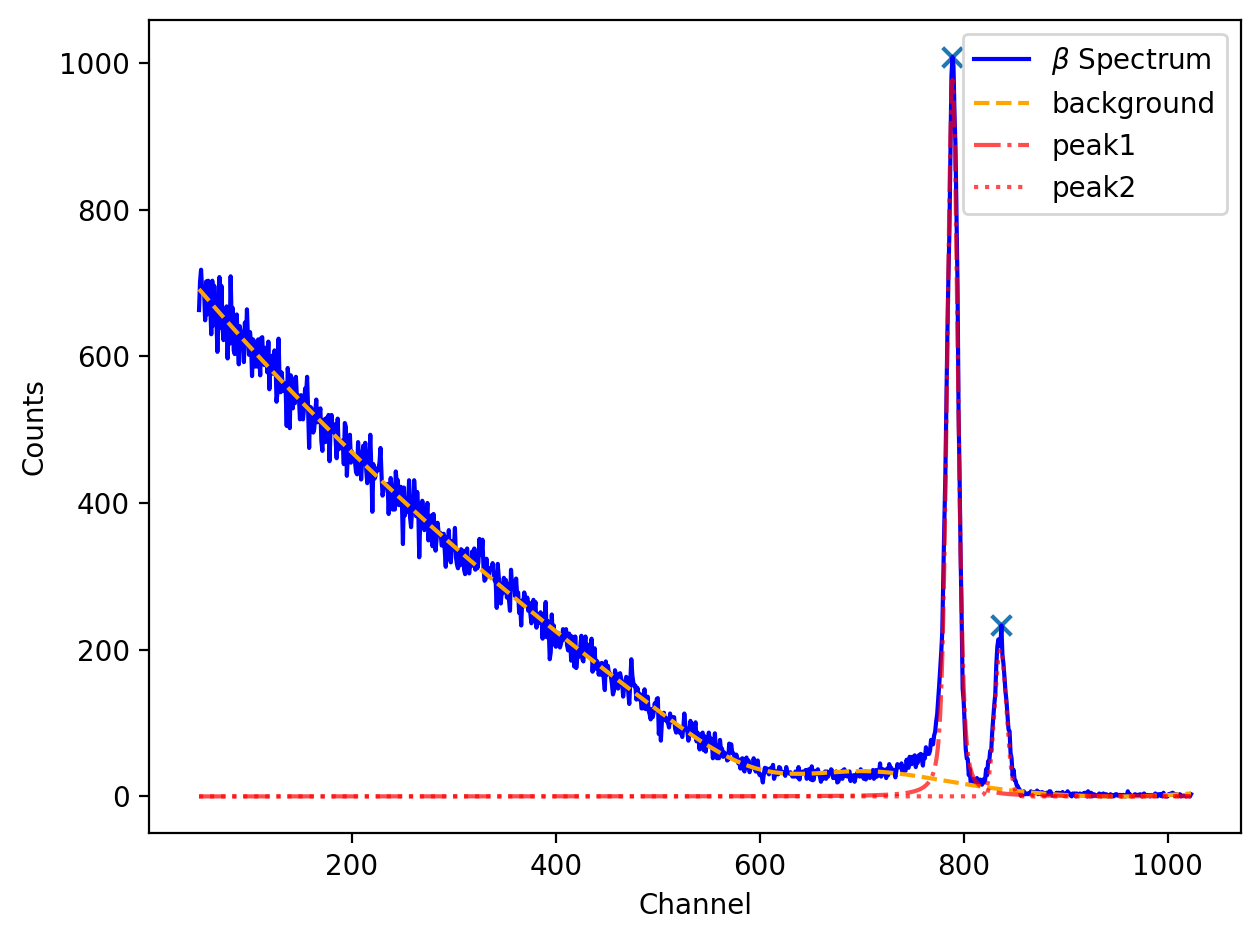

In [15]:
# ax.plot(channel_dropped,out.best_fit,'r',label='fit')
comps = out.eval_components()
ax.plot(channel_dropped, comps['bkg_'], color = 'orange',label='background',linestyle = '--')
ax.plot(channel_dropped, comps['peak1_'],color='red', label='peak1',linestyle = '-.',alpha = 0.7)
ax.plot(channel_dropped, comps['peak2_'],color='red', label='peak2',linestyle = 'dotted',alpha = 0.7)
ax.legend()
fig.tight_layout()
fig.savefig(path+'beta_spetrum.pdf')
fig

In [16]:
interesting_para = {i[0]:i[1].value for i in out.params.items() if i[0][:5]=='peak2'}
# for i in out.params.items():
#     print(i[0][:5])
#     print(i[1].value)
interesting_para

{'peak2_amplitude': 2869.100091337534,
 'peak2_center': 836.1427796958336,
 'peak2_sigma': 5.698245449439698,
 'peak2_gamma': 7.076024211016829e-08,
 'peak2_fwhm': 13.418228411600598,
 'peak2_height': 200.86978210282163}

In [17]:
Channel_inner = out.params['peak1_center'].value
E_inner = 625 #keV

1.2075780915652834


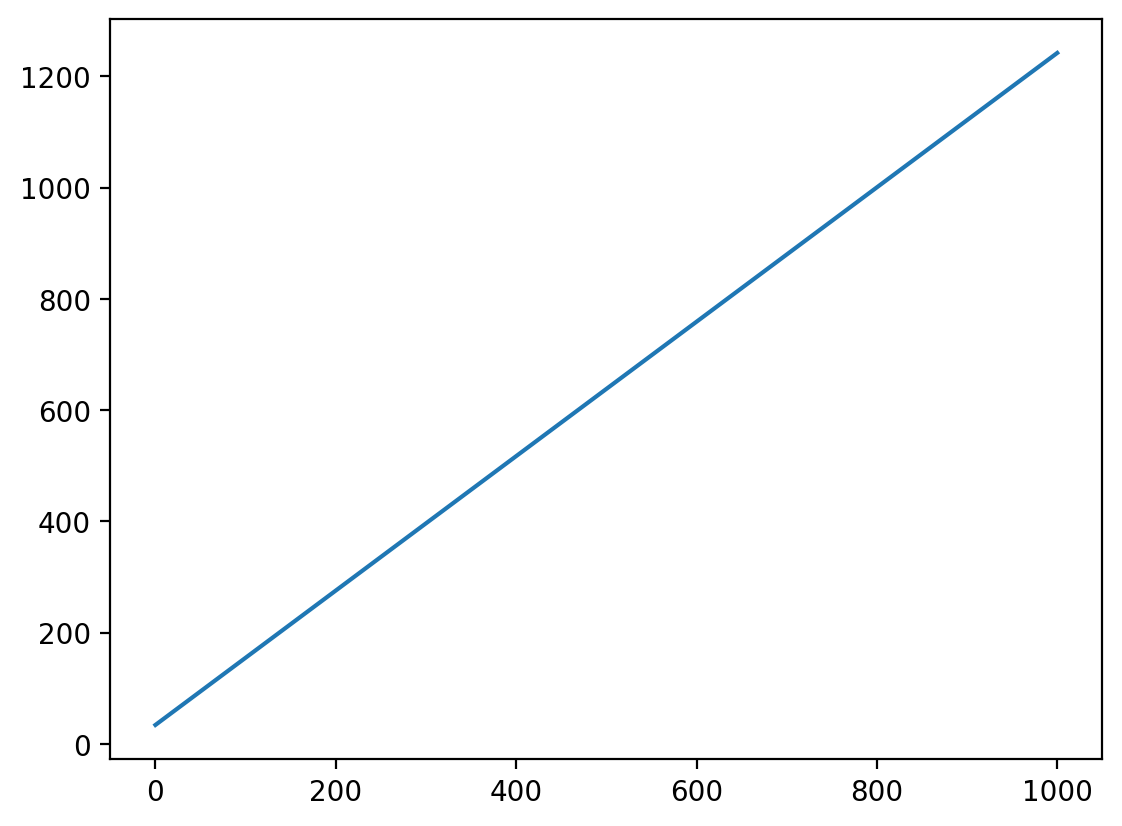

In [18]:
celi_A = (Channel_inner-celi_B)/E_inner
print(celi_A)
def celibration(Energy):
    return celi_A*Energy+celi_B

Ene_plot = np.linspace(0,1000,1001)
channel_plot = celibration(Ene_plot)
plt.plot(Ene_plot,channel_plot)
plt.show()

# RAW

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 5
    # variables        = 2
    chi-square         = 533.195196
    reduced chi-square = 177.731732
    Akaike info crit   = 27.3472483
    Bayesian info crit = 26.5661242
    R-squared          = 0.99730143
[[Variables]]
    slope:      36.0186453 +/- 1.08173468 (3.00%) (init = 1)
    intercept: -82.7350679 +/- 15.9540281 (19.28%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9275


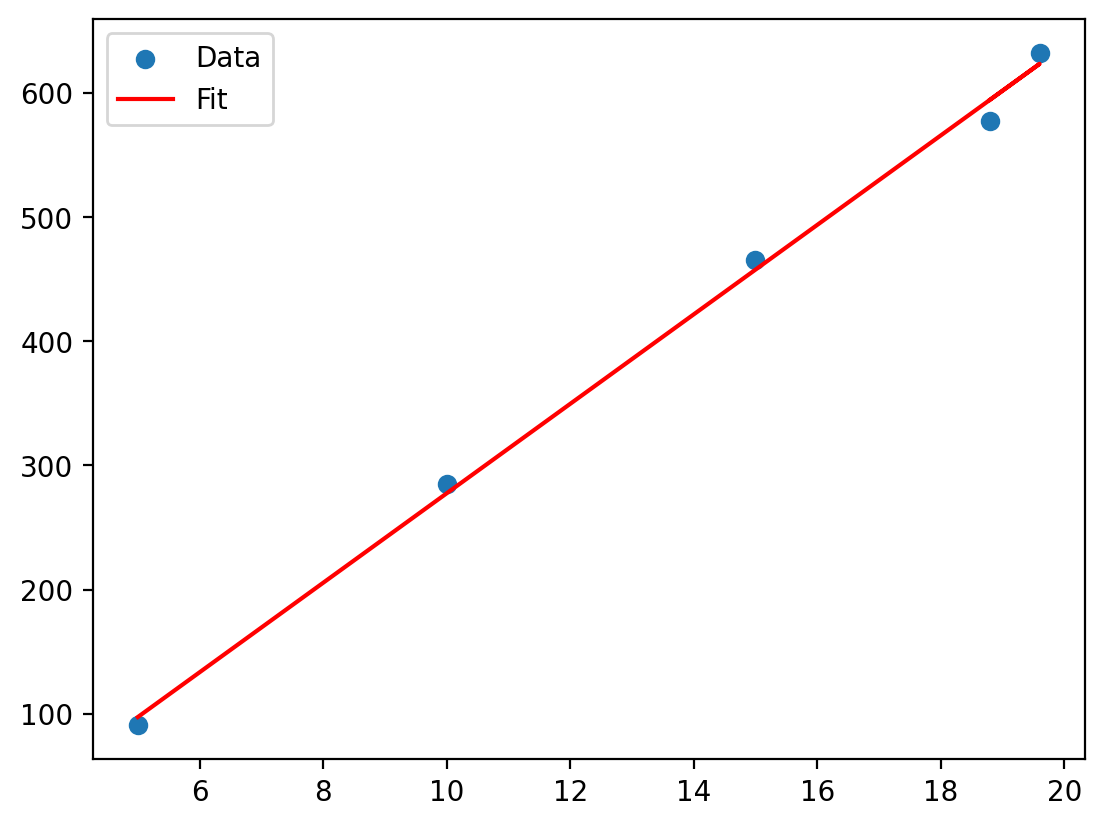

In [19]:
from lmfit.models import LinearModel
import matplotlib.pyplot as plt

# Create data
x = [18.8,19.6,15.0,10.0,5.0]
y = [577,632,465,285,91]

# Initialize the linear model and fit the data
linear_model = LinearModel()
fit_result = linear_model.fit(y, x=x)

# Print the fit report
print(fit_result.fit_report())

# Plot the data and fitted line
plt.scatter(x, y, label='Data')
plt.plot(x, fit_result.best_fit, label='Fit', color='r')
plt.legend()
plt.show()

In [20]:
import pandas as pd

# Given data
x = [18.8, 19.6, 15.0, 10.0, 5.0]
y = [577, 632, 465, 285, 91]

# Create a DataFrame
data = {r'amplitude(mV)': x, 'Peak_position': y}
df = pd.DataFrame(data)

# Display the DataFrame
df.to_csv('linear_celibration.csv')

In [21]:
fit_result